In [2]:
import matplotlib.pyplot as plt
from sklearn import tree

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import pandas as pd
import joblib
import json
import sys 
sys.path.append('..')

from utilities import health_data
from utilities import configuration

config = configuration.get_config()
print('configuration loaded')

configuration loaded


#### Auxiliary Function to compute metrics

In [4]:
def get_metric_evaluations(evaluated_model, X, y_true, description=''):
    y_pred = evaluated_model.predict(X)
    y_score = evaluated_model.predict_proba(X)[:,1]

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    training_results = {'Description': description,
                        'Precision': precision_score(y_true, y_pred),
                        'Recal': recall_score(y_true, y_pred),
                        'F1-Score': f1_score(y_true, y_pred),
                        'AUC': roc_auc_score(y_true=y_true, y_score=y_score),
                        'TN': tn,
                        'TP': tp,
                        'FN': fn,
                        'FP': fp,
                        }
    results = {key: [training_results[key]] for key in training_results.keys()}
    return pd.DataFrame(results)

#### Obtaining train and test matrices 

In [5]:
experiment_configurations = json.load(open(config['experiments_config'], encoding='utf-8'))
X_train, y_train, X_test, y_test, columns = health_data.Admission.get_train_test_matrices(experiment_configurations['configuration_82'])

2024-02-04 17:27:55,048 - root - DEBUG - Calling Admission.get_training_testing_date(combining_diagnoses=False, combining_interventions=False)


Enter key for decryption:  ········


 0 matrix.shape=(419139, 5)
 1 matrix.shape=(419139, 68)
 2 matrix.shape=(419139, 8011)
 3 matrix.shape=(419139, 5572)
2024-02-04 17:29:42,846 - root - DEBUG - Using X_train, y_train, no samplig strategy ...
2024-02-04 17:29:42,848 - root - DEBUG - Looking for constant variables ...
2024-02-04 17:29:42,849 - root - DEBUG - Using memory efficient solution
2024-02-04 17:37:11,856 - root - DEBUG - Not constant variables found ...
2024-02-04 17:37:11,903 - root - DEBUG - Shapes of matrices before FS...
2024-02-04 17:37:11,905 - root - DEBUG - X_train: (419139, 13656)
2024-02-04 17:37:11,906 - root - DEBUG - y_train: (419139,)
2024-02-04 17:37:11,907 - root - DEBUG - X_test:  (104884, 13656)
2024-02-04 17:37:11,908 - root - DEBUG - y_test:  (104884,)


#### Obtaining black-box model (BRF)


In [4]:
from imblearn.ensemble import BalancedRandomForestClassifier
from_disk = false

if from_disk:
    brf = joblib.load(config['balanced_random_forest_path'])
else:

    brf = BalancedRandomForestClassifier(n_estimators=500, 
                                        sampling_strategy='majority', 
                                        replacement=True, 
                                        class_weight='balanced_subsample')
    brf.fit(X_train, y_train)

In [8]:
import joblib

pd.concat([
            get_metric_evaluations(brf, X_train, y_train, description='BRF training'),
            get_metric_evaluations(brf, X_test, y_test, description='BRF testing'),
          ])

,Description,Precision,Recal,F1-Score,AUC,TN,TP,FN,FP
0,BRF training,0.105261,0.996207,0.190403,0.990803,254377,17336,66,147360
0,BRF testing,0.078735,0.739466,0.142317,0.738059,61130,3352,1181,39221


In [11]:
from sklearn.tree import DecisionTreeClassifier
surrogate_model = DecisionTreeClassifier(max_depth=3)
print('Training ...')
yhat_train = brf.predict(X_train)
yhat_test = brf.predict(X_test)

surrogate_model.fit(X_train, yhat_train, )


fig, ax = plt.subplots(figsize=(10,10))
tree.plot_tree(surrogate_model, feature_names=list(columns), class_names=['NR', 'R'])
fig.savefig(surrogate_decision_tree_figure)


df = pd.concat([
            get_metric_evaluations(surrogate_model, X_train, y_train, description='DT training'),
            get_metric_evaluations(surrogate_model, X_test, y_test, description='DT testing'),
            get_metric_evaluations(surrogate_model, X_train, yhat_train, description='DT training (comp BRF)'),
            get_metric_evaluations(surrogate_model, X_test, yhat_test, description='DT testing (comp BRF)'),
          ])
print('Done')
df

Done


,Description,Precision,Recal,F1-Score,AUC,TN,TP,FN,FP
0,DT training,0.063855,0.649466,0.116278,0.642138,236045,11302,6100,165692
0,DT testing,0.066662,0.652327,0.120963,0.642485,58950,2957,1576,41401
0,DT training (comp BRF),0.670616,0.720691,0.694753,0.799297,196144,118695,46001,58299
0,DT testing (comp BRF),0.691510,0.720504,0.705709,0.807436,48627,30674,11899,13684


In [ ]:
config = configuration.get_config()



In [10]:
from sklearn.linear_model import LogisticRegression
surrogate_model_lr = LogisticRegression(class_weight='balanced', max_iter=7000)
# print('Training ...')
# yhat_train = brf.predict(X_train)
# yhat_test = brf.predict(X_test)

surrogate_model_lr.fit(X_train, yhat_train, )
print('Done')

pd.concat([
            get_metric_evaluations(surrogate_model_lr, X_train, y_train, description='LR training'),
            get_metric_evaluations(surrogate_model_lr, X_test, y_test, description='LR testing'),
            get_metric_evaluations(surrogate_model_lr, X_train, yhat_train, description='LR training (comp BRF)'),
            get_metric_evaluations(surrogate_model_lr, X_test, yhat_test, description='LR testing (comp BRF)'),
          ])

/lustre03/project/6076769/maiso/environments/alc/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Done


,Description,Precision,Recal,F1-Score,AUC,TN,TP,FN,FP
0,LR training,0.072712,0.754396,0.132640,0.728418,234317,13128,4274,167420
0,LR testing,0.074716,0.743216,0.135781,0.722739,58629,3369,1164,41722
0,LR training (comp BRF),0.804556,0.881995,0.841498,0.944379,219156,145261,19435,35287
0,LR testing (comp BRF),0.831518,0.880699,0.855402,0.950966,54714,37494,5079,7597


In [ ]:
# experiment_configurations = json.load(open(config['experiments_config'], encoding='utf-8'))
# X_train, y_train, X_test, y_test, columns = health_data.Admission.get_train_test_matrices(experiment_configurations['configuration_31'])

In [10]:
# print(f'X_train.shape={X_train.shape}')
# print(f'y_train.shape={y_train.shape}')

# print(f'X_test.shape= {X_train.shape}')
# print(f'y_test.shape= {y_train.shape}')
# print(f'len(columns)= {len(columns)}')

X_train.shape=(419139, 17137)
y_train.shape=(419139,)
X_test.shape= (419139, 17137)
y_test.shape= (419139,)
len(columns)= 17137


In [11]:
# from imblearn.ensemble import BalancedRandomForestClassifier

In [12]:
# model = BalancedRandomForestClassifier(n_estimators=501, 
#                                     sampling_strategy='majority', 
#                                     replacement=True, 
#                                     class_weight='balanced_subsample')

In [13]:
# model.fit(X_train, y_train)

BalancedRandomForestClassifier(class_weight='balanced_subsample',
                               n_estimators=501, replacement=True,
                               sampling_strategy='majority')

In [14]:
# import joblib
# config = configuration.get_config()
# joblib.dump(model, config['balanced_random_forest_path']) 


['/home/maiso/cbu/repositories/alternate-level-of-care-project/checkpoints/balanced_random_forest.joblib']

In [18]:

# from sklearn.tree import DecisionTreeClassifier
# surrogate_model = DecisionTreeClassifier(max_depth=3)
# surrogate_model.fit(X_train, yhat, )


In [19]:
# from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# y_pred = model2.predict(X_train)
# y_score = model2.predict_proba(X_train)[:,1]
# y_true = y_train

# tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# training_results = {'Model Name': 'BRF',
#                     'Split': 'TRAIN',
#                     'Precision': precision_score(y_true, y_pred),
#                     'Recal': recall_score(y_true, y_pred),
#                     'F1-Score': f1_score(y_true, y_pred),
#                     'AUC': roc_auc_score(y_true=y_true, y_score=y_score),
#                     'TN': tn,
#                     'TP': tp,
#                     'FN': fn,
#                     'FP': fp,
#                     }

# # ---------- ---------- ---------- ---------- #
# # COMPUTING METRICS (TESTING SPLIT)           #
# # ---------- ---------- ---------- ---------- #
# y_pred = model2.predict(X_test)
# y_score = model2.predict_proba(X_test)[:,1]
# y_true = y_test

# tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
# testing_results = {'Model Name': 'BRF',
#                    'Split': 'TEST',
#                    'Precision': precision_score(y_true, y_pred),
#                    'Recal': recall_score(y_true, y_pred),
#                    'F1-Score': f1_score(y_true, y_pred),
#                    'AUC': roc_auc_score(y_true=y_true, y_score=y_score),
#                    'TN': tn,
#                    'TP': tp,
#                    'FN': fn,
#                    'FP': fp
#                    }

# # ---------- ---------- ---------- ---------- #
# # APPENDING NEW RESULTS TO RESULT FILES       #
# # ---------- ---------- ---------- ---------- #
# results = {key: [training_results[key], testing_results[key]] for key in training_results.keys()}

# df = pd.DataFrame(results)
# df

,Model Name,Split,Precision,Recal,F1-Score,AUC,TN,TP,FN,FP
0,BRF,TRAIN,0.104572,0.996265,0.189277,0.991604,253284,17337,65,148453
1,BRF,TEST,0.078615,0.745864,0.142238,0.737944,60725,3381,1152,39626


In [21]:
yhat = model.predict(X_train)

In [25]:
surrogate_model.fit(X_train, yhat, )

DecisionTreeClassifier(max_depth=3)

In [26]:
# from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# y_pred = surrogate_model.predict(X_train)
# y_score = surrogate_model.predict_proba(X_train)[:,1]
# y_true = y_train

# tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# training_results = {'Model Name': 'BRF',
#                     'Split': 'TRAIN',
#                     'Precision': precision_score(y_true, y_pred),
#                     'Recal': recall_score(y_true, y_pred),
#                     'F1-Score': f1_score(y_true, y_pred),
#                     'AUC': roc_auc_score(y_true=y_true, y_score=y_score),
#                     'TN': tn,
#                     'TP': tp,
#                     'FN': fn,
#                     'FP': fp,
#                     }

# # ---------- ---------- ---------- ---------- #
# # COMPUTING METRICS (TESTING SPLIT)           #
# # ---------- ---------- ---------- ---------- #
# y_pred = surrogate_model.predict(X_test)
# y_score = surrogate_model.predict_proba(X_test)[:,1]
# y_true = y_test

# tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
# testing_results = {'Model Name': 'BRF',
#                    'Split': 'TEST',
#                    'Precision': precision_score(y_true, y_pred),
#                    'Recal': recall_score(y_true, y_pred),
#                    'F1-Score': f1_score(y_true, y_pred),
#                    'AUC': roc_auc_score(y_true=y_true, y_score=y_score),
#                    'TN': tn,
#                    'TP': tp,
#                    'FN': fn,
#                    'FP': fp
#                    }

# # ---------- ---------- ---------- ---------- #
# # APPENDING NEW RESULTS TO RESULT FILES       #
# # ---------- ---------- ---------- ---------- #
# results = {key: [training_results[key], testing_results[key]] for key in training_results.keys()}

# df = pd.DataFrame(results)
# df

,Model Name,Split,Precision,Recal,F1-Score,AUC,TN,TP,FN,FP
0,BRF,TRAIN,0.063891,0.649523,0.116338,0.642151,236129,11303,6099,165608
1,BRF,TEST,0.066655,0.651886,0.120943,0.642172,58973,2955,1578,41378


In [28]:
# from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# y_pred = surrogate_model.predict(X_train)
# y_score = surrogate_model.predict_proba(X_train)[:,1]
# y_true = model.predict(X_train)

# tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# training_results = {'Model Name': 'BRF',
#                     'Split': 'TRAIN',
#                     'Precision': precision_score(y_true, y_pred),
#                     'Recal': recall_score(y_true, y_pred),
#                     'F1-Score': f1_score(y_true, y_pred),
#                     'AUC': roc_auc_score(y_true=y_true, y_score=y_score),
#                     'TN': tn,
#                     'TP': tp,
#                     'FN': fn,
#                     'FP': fp,
#                     }
# results = {key: [training_results[key]] for key in training_results.keys()}

# df = pd.DataFrame(results)
# df

,Model Name,Split,Precision,Recal,F1-Score,AUC,TN,TP,FN,FP
0,BRF,TRAIN,0.669591,0.714506,0.69132,0.797359,194896,118458,47332,58453


[Text(0.5, 0.875, 'urgent admission <= 0.5\ngini = 0.478\nsamples = 419139\nvalue = [253349, 165790]\nclass = NR'),
 Text(0.25, 0.625, 'case_weight <= 1.558\ngini = 0.171\nsamples = 128361\nvalue = [116251, 12110]\nclass = NR'),
 Text(0.125, 0.375, 'z511 <= 0.144\ngini = 0.1\nsamples = 104877\nvalue = [99325, 5552]\nclass = NR'),
 Text(0.0625, 0.125, 'gini = 0.091\nsamples = 104236\nvalue = [99263, 4973]\nclass = NR'),
 Text(0.1875, 0.125, 'gini = 0.175\nsamples = 641\nvalue = [62, 579]\nclass = R'),
 Text(0.375, 0.375, 'General Surgery <= 0.5\ngini = 0.403\nsamples = 23484\nvalue = [16926, 6558]\nclass = NR'),
 Text(0.3125, 0.125, 'gini = 0.295\nsamples = 18339\nvalue = [15043, 3296]\nclass = NR'),
 Text(0.4375, 0.125, 'gini = 0.464\nsamples = 5145\nvalue = [1883, 3262]\nclass = R'),
 Text(0.75, 0.625, 'New Acute Patient <= 0.5\ngini = 0.498\nsamples = 290778\nvalue = [137098, 153680]\nclass = R'),
 Text(0.625, 0.375, 'cmg <= 725.5\ngini = 0.475\nsamples = 209935\nvalue = [81492, 1284

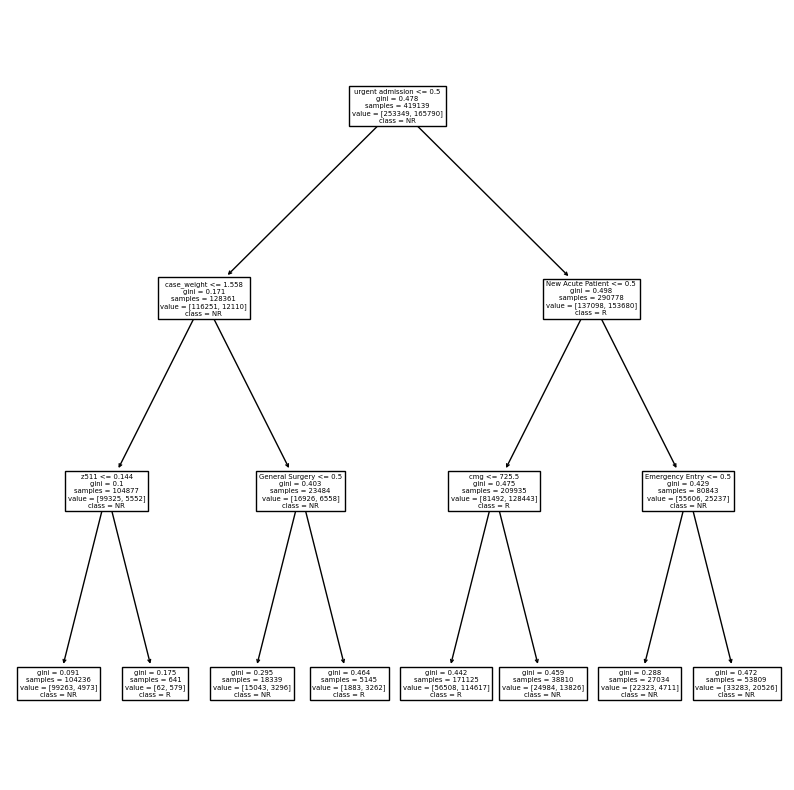

In [33]:
import matplotlib.pyplot as plt
from sklearn import tree

fig, ax = plt.subplots(figsize=(10,10))
tree.plot_tree(surrogate_model, feature_names=list(columns), class_names=['NR', 'R'])

In [37]:
def get_metric_evaluations(evaluated_model, y_true):
    y_pred = evaluated_model.predict(X_train)
    y_score = evaluated_model.predict_proba(X_train)[:,1]
    y_true = y_true

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    training_results = {'Model Name': 'BRF',
                        'Split': 'TRAIN',
                        'Precision': precision_score(y_true, y_pred),
                        'Recal': recall_score(y_true, y_pred),
                        'F1-Score': f1_score(y_true, y_pred),
                        'AUC': roc_auc_score(y_true=y_true, y_score=y_score),
                        'TN': tn,
                        'TP': tp,
                        'FN': fn,
                        'FP': fp,
                        }
    results = {key: [training_results[key]] for key in training_results.keys()}
    
    return pd.DataFrame(results)




In [38]:
get_metric_evaluations(surrogate_model, yhat)

,Model Name,Split,Precision,Recal,F1-Score,AUC,TN,TP,FN,FP
0,BRF,TRAIN,0.669591,0.714506,0.69132,0.797359,194896,118458,47332,58453


In [ ]:
get_metric_evaluations